# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src="/content/cautleya_spicata.jpg" width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
import json

In [2]:
%pip install tfds-nightly


In [3]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.2.0
	• tf.keras version: 2.3.0-tf
	• Running on GPU


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [4]:
# TODO: Load the dataset with TensorFlow Datasets.
train_split = 60
test_val_split = 20


(training_set, validation_set, test_set), dataset_info = tfds.load("oxford_flowers102", split=['train', 'test', 'validation'], as_supervised=True, with_info=True)


In [5]:
#Dataset info
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=2.1.1,
    description='The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).',
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples=8

In [6]:
#Assign number of classes in dataset
num_classes = dataset_info.features['label'].num_classes

#Assign total examples
total_num_examples = dataset_info.splits['train'].num_examples


In [7]:
#Take and print three images for reference
for image, label in training_set.take(3):
    print('The images in the training set have:\n\u2022 dtype:', image.dtype, '\n\u2022 shape:', image.shape)

The images in the training set have:
• dtype: <dtype: 'uint8'> 
• shape: (500, 667, 3)
The images in the training set have:
• dtype: <dtype: 'uint8'> 
• shape: (500, 666, 3)
The images in the training set have:
• dtype: <dtype: 'uint8'> 
• shape: (670, 500, 3)


### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers. Since I worked in Google Collab, the file was in '/content/label_map (1).json'

In [8]:
#Load json file to map class ids to class names.
with open('/content/label_map.json', 'r') as f:
    class_names = json.load(f)

In [9]:
#Look at the first 10 names int he json file.
for i in range(10):
  print(f"{i+1} title with corresponding class name{class_names[str(i+1)]}" )

1 title with corresponding class namepink primrose
2 title with corresponding class namehard-leaved pocket orchid
3 title with corresponding class namecanterbury bells
4 title with corresponding class namesweet pea
5 title with corresponding class nameenglish marigold
6 title with corresponding class nametiger lily
7 title with corresponding class namemoon orchid
8 title with corresponding class namebird of paradise
9 title with corresponding class namemonkshood
10 title with corresponding class nameglobe thistle


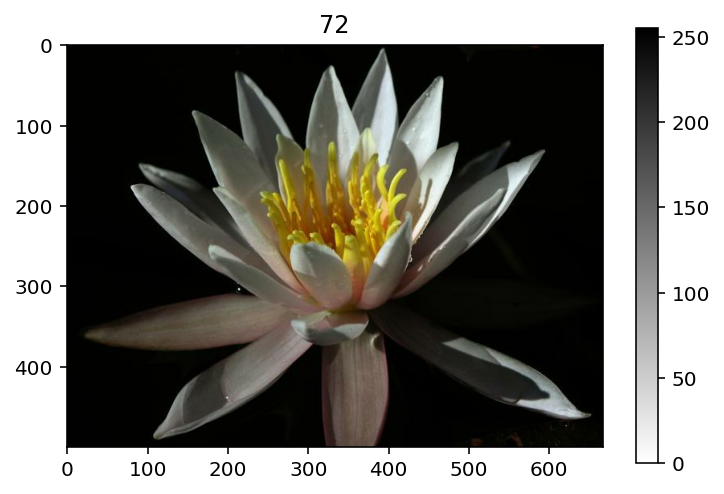

The label of this image is: 72


In [10]:
#Print image with current image label 
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.imshow(image, cmap= plt.cm.binary)
plt.title(str(label))
plt.colorbar()
plt.show()

print('The label of this image is:', label)


In [11]:
#Print the number of samples in training set, validation set and test set.

total_examples = dataset_info.splits['train'].num_examples + dataset_info.splits['test'].num_examples

num_training_examples = (total_examples * train_split) // 100
num_validation_examples = (total_examples * test_val_split) // 100
num_test_examples = num_validation_examples

print('There are {:,} images in the training set'.format(num_training_examples))
print('There are {:,} images in the validation set'.format(num_validation_examples))
print('There are {:,} images in the test set'.format(num_test_examples))

There are 4,301 images in the training set
There are 1,433 images in the validation set
There are 1,433 images in the test set


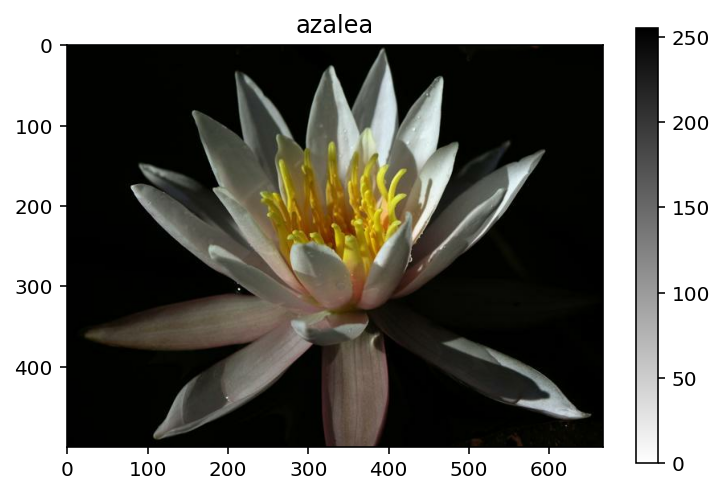

The label of this image is: 72


In [12]:
#Print image with class name from json mapping file
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.imshow(image, cmap= plt.cm.binary)
plt.title(class_names[str(label)])
plt.colorbar()
plt.show()

print('The label of this image is:', label)


## Create Pipeline


In [13]:
#Batch size for ingestion and image_size to meet tensorflow requirements.
batch_size = 32
image_size = 224


num_training_examples = (total_num_examples * train_split) // 100

def format_image(image, label):
    '''
    Function takes image and creates a tensor and resizes the image.
    INPUT: image: numpy with pixels
           label: str
    OUPTUT: Tensor 
    '''
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label

#Create batches for training, validation and testing sets.
training_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation_set.map(format_image).batch(batch_size).prefetch(1)
testing_batches = test_set.map(format_image).batch(batch_size).prefetch(1)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [14]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))

In [15]:
feature_extractor.trainable = False

In [31]:
class Network(tf.keras.Model):
  def __init__(self, num_classes = 10):
    super().__init__()
    self.num_classes = num_classes

    self.input_layer = feature_extractor
    self.hidden_layer_1 = tf.keras.layers.Dense(512,activation='relu')
    self.drop_out =    tf.keras.layers.Dropout(0.3)
    self.hidden_layer_2 = tf.keras.layers.Dense(256,activation='relu')
    self.drop_out_2 =   tf.keras.layers.Dropout(0.2)
    self.hidden_layer_3 = tf.keras.layers.Dense(128,activation='relu')
    self.output_layer =  tf.keras.layers.Dense(num_classes, activation='softmax')
    
  def call(self, input_tensor):
    x = self.input_layer(input_tensor)
    x = self.hidden_layer_1(x)
    x = self.drop_out(x)
    x = self.hidden_layer_2(x)
    x = self.drop_out_2(x)
    x = self.hidden_layer_3(x)
    x = self.drop_out_2(x)
    x = self.output_layer(x)
    return x




In [32]:
model_sub = Network(num_classes = num_classes)

In [33]:
model_sub.build((None, image_size, image_size,3))

In [34]:
model_sub.summary()

Model: "network_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  2257984   
_________________________________________________________________
dense_4 (Dense)              multiple                  655872    
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_5 (Dense)              multiple                  131328    
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  32896     
_________________________________________________________________
dense_7 (Dense)              multiple                  13

### Using the sequential model instead of the subclass model.
For the project I have to create a h5 model and then reload it. The subclass model cannot be written into an h5 file because the model is defined in python which cannot be serialized correctly. For the sake of this project I will continue with the sequential model.

In [47]:

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_8 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0

In [48]:
print('Is there a GPU Available:', tf.test.is_gpu_available())

Is there a GPU Available: True


In [49]:
## Solution
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



In [50]:
# Stop training when there is no improvement in the validation loss for 10 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Save the Model with the lowest validation loss
save_best = tf.keras.callbacks.ModelCheckpoint('./my_model.h5',
                                               monitor='val_loss',
                                               save_best_only=True,
                                               save_weights_only=False)
history = model.fit(training_batches,
                    epochs = 100,
                    validation_data=validation_batches,
                    callbacks=[early_stopping, save_best])

Epoch 1/100
32/32 [==============================] - 20s 635ms/step - loss: 4.6606 - accuracy: 0.0176 - val_loss: 4.4969 - val_accuracy: 0.0486
Epoch 2/100
32/32 [==============================] - 20s 619ms/step - loss: 4.2982 - accuracy: 0.0578 - val_loss: 4.0223 - val_accuracy: 0.1599
Epoch 3/100
32/32 [==============================] - 20s 619ms/step - loss: 3.6309 - accuracy: 0.1775 - val_loss: 3.1074 - val_accuracy: 0.3300
Epoch 4/100
32/32 [==============================] - 20s 616ms/step - loss: 2.7342 - accuracy: 0.3098 - val_loss: 2.4251 - val_accuracy: 0.4302
Epoch 5/100
32/32 [==============================] - 20s 616ms/step - loss: 2.1763 - accuracy: 0.4265 - val_loss: 1.9581 - val_accuracy: 0.5339
Epoch 6/100
32/32 [==============================] - 20s 610ms/step - loss: 1.6925 - accuracy: 0.5412 - val_loss: 1.7190 - val_accuracy: 0.5731
Epoch 7/100
32/32 [==============================] - 20s 620ms/step - loss: 1.2583 - accuracy: 0.6382 - val_loss: 1.5748 - val_accuracy:

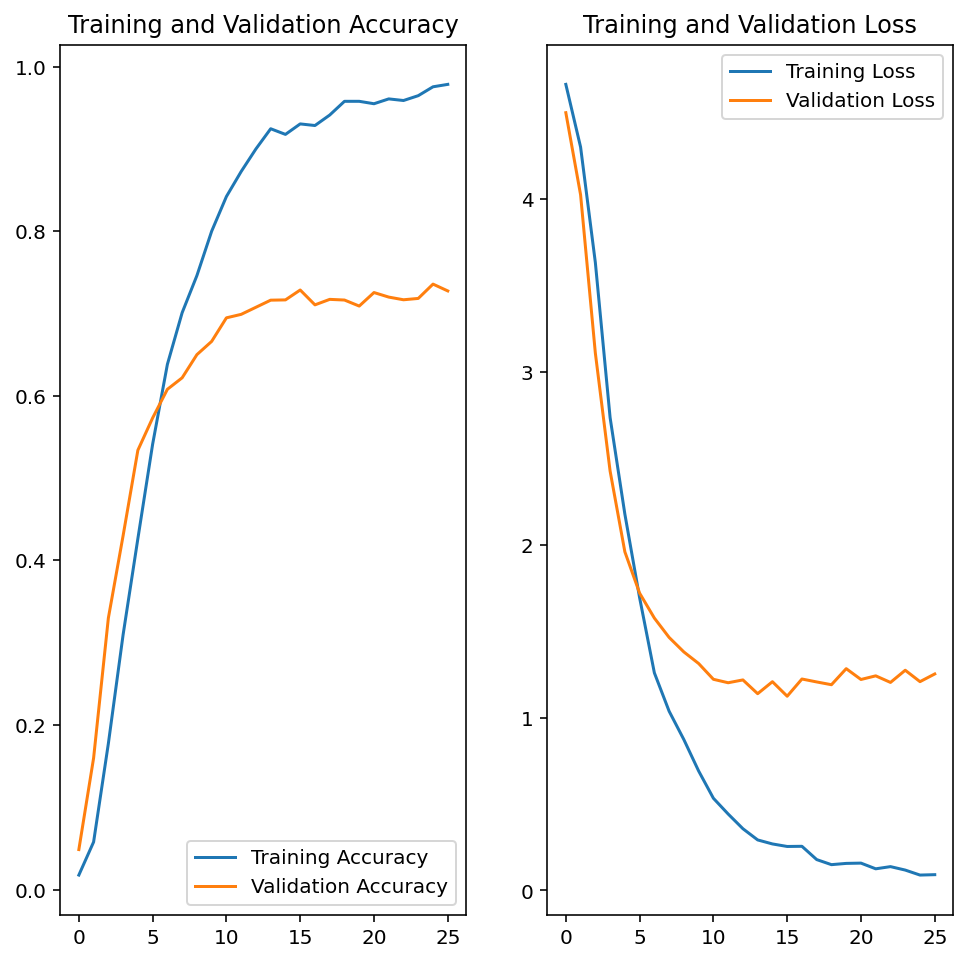

In [52]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
reloaded_keras_model = tf.keras.models.load_model('/content/my_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})


In [54]:
reloaded_keras_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_8 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0

## Evaluate Loss and Accuracy on the Test Set

Now let's see how the model performs on the test set. This time, we will use all the examples in our test set to assess the loss and accuracy of our model. Remember, the images in the test are images the model has never seen before.

In [55]:
loss, accuracy = reloaded_keras_model.evaluate(testing_batches)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

32/32 [==============================] - 3s 91ms/step - loss: 0.9501 - accuracy: 0.7461

Loss on the TEST Set: 0.950
Accuracy on the TEST Set: 74.608%


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [56]:
def process_image(numpy_image):
    '''
    Function takes an image and resizes it
    INPUT: numpy array
    OUTPUT: numpy for ingestion.
    
    '''
    print(numpy_image.shape)    

    return (tf.image.resize(numpy_image,(image_size,image_size)).numpy()/255)

(750, 500, 3)


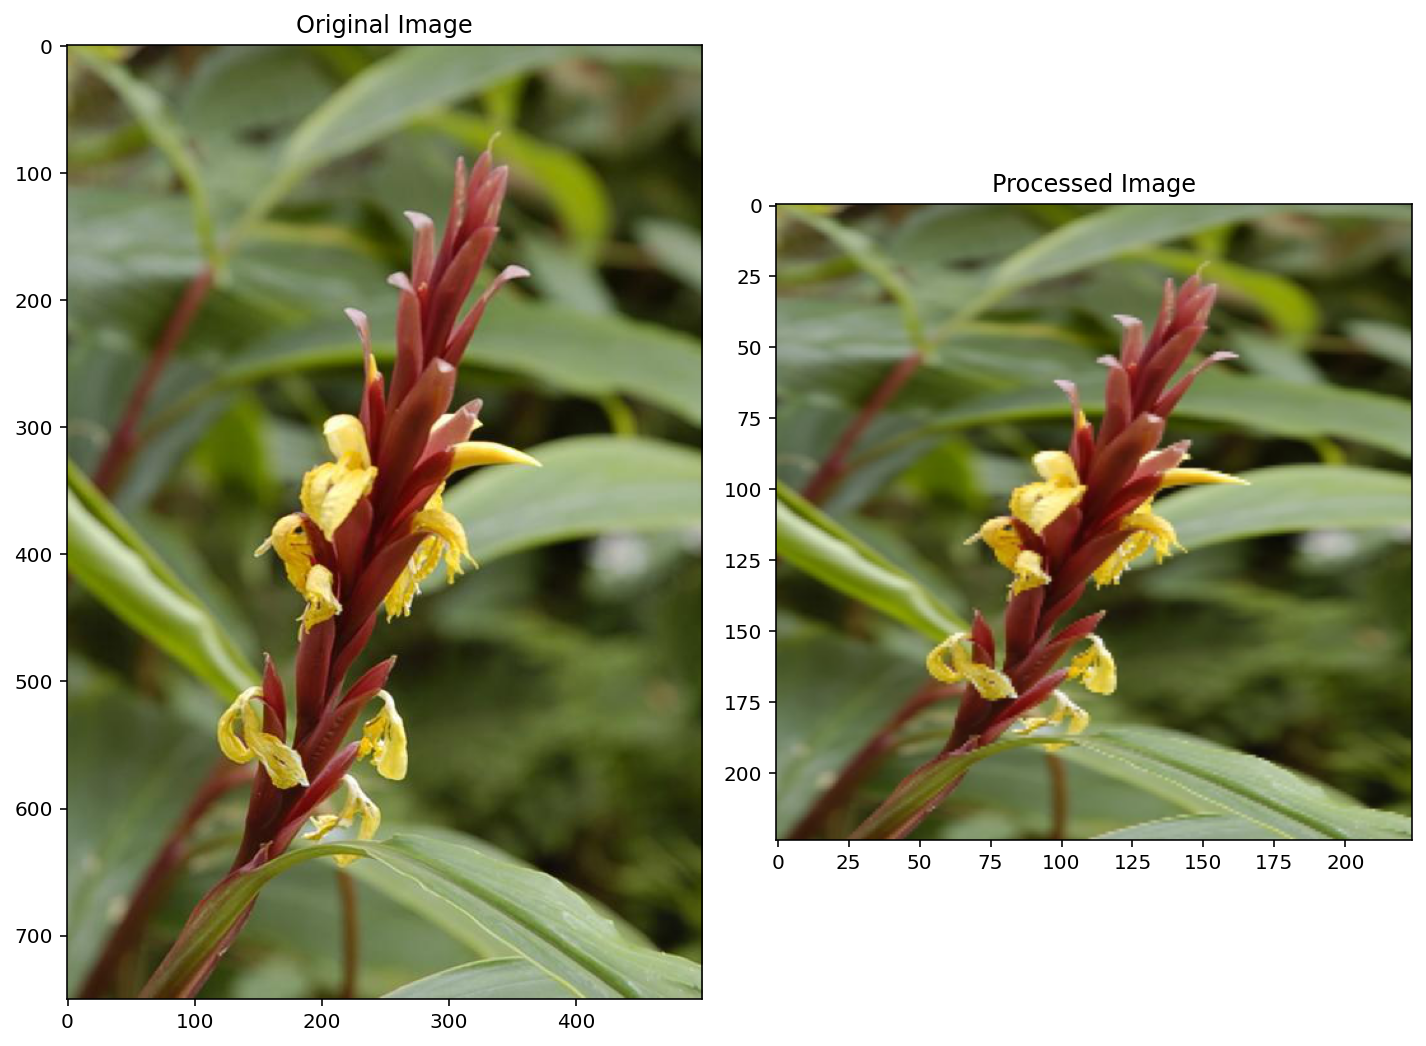

In [57]:
from PIL import Image

image_path = '/content/cautleya_spicata.jpg'
im = Image.open(image_path)
image_numpy = np.asarray(im)

processed_image = process_image(image_numpy)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(image_numpy)
ax1.set_title('Original Image')
ax2.imshow(processed_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [58]:

def predict(image_path, model, top_k):
    '''
    Function takes inputs and prints top predicted class name, label and probability for flower image.
    It also prints the top k results for flower image.
    
    INPUT: image_path - (str) path to image.
           model_path - (Tensor Model) 
           top_k - (int) Requested top k results.
    OUTPUT: NONE    
    '''
    
    img = Image.open(image_path)
    image = np.asarray(img)

    processed_image = process_image(image)

    print(np.expand_dims(processed_image,axis=0).shape)

    prob_preds = model.predict(np.expand_dims(processed_image,axis=0))
    prob_preds = prob_preds[0]


    values, indices= tf.math.top_k(prob_preds, k=top_k)

    #Tranforming tensors to numpy for use
    probs=values.numpy().tolist()
    classes=indices.numpy().tolist()

    return probs, classes

In [59]:
probs, classes = predict('/content/wild_pansy.jpg',reloaded_keras_model, 5)


(558, 500, 3)
(1, 224, 224, 3)


In [60]:
classes

[51, 18, 33, 83, 63]

In [61]:
#There is an error in the json mapping file. Need to add 1 to get the correct result.
pred_name =[]
for i in classes:
  pred_name.append(class_names[str(i+1)])
print("prediction probabilities :\n",probs)
print('prediction classes:\n',classes)
print('prediction labels:\n',pred_name)

prediction probabilities :
 [0.9997356534004211, 0.00010053516598418355, 3.342319905641489e-05, 3.2309875678038225e-05, 1.844486359914299e-05]
prediction classes:
 [51, 18, 33, 83, 63]
prediction labels:
 ['wild pansy', 'balloon flower', 'mexican aster', 'columbine', 'silverbush']


# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

In [62]:
images  = ["/content/cautleya_spicata.jpg", "/content/hard-leaved_pocket_orchid.jpg", "/content/orange_dahlia.jpg", "/content/wild_pansy.jpg" ]

In [63]:
def plot_image(image, model, top_k):
  prob, classes = predict(image, model, top_k)
  labels = [class_names[str(i+1)] for i in classes]

  im = Image.open(image)
  test_image = np.asarray(im)

  fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
  ax1.imshow(test_image, cmap = plt.cm.binary)
  ax1.axis('off')
  ax1.set_title(image)
  ax2.barh(np.arange(top_k), prob)
  ax2.set_aspect(0.1)
  ax2.set_yticks(np.arange(top_k))
  ax2.set_yticklabels(labels, size='small');
  ax2.set_title('Class Probability')
  ax2.set_xlim(0, 1.1)
  plt.tight_layout()

(750, 500, 3)
(1, 224, 224, 3)
(591, 500, 3)
(1, 224, 224, 3)
(752, 500, 3)
(1, 224, 224, 3)
(558, 500, 3)
(1, 224, 224, 3)


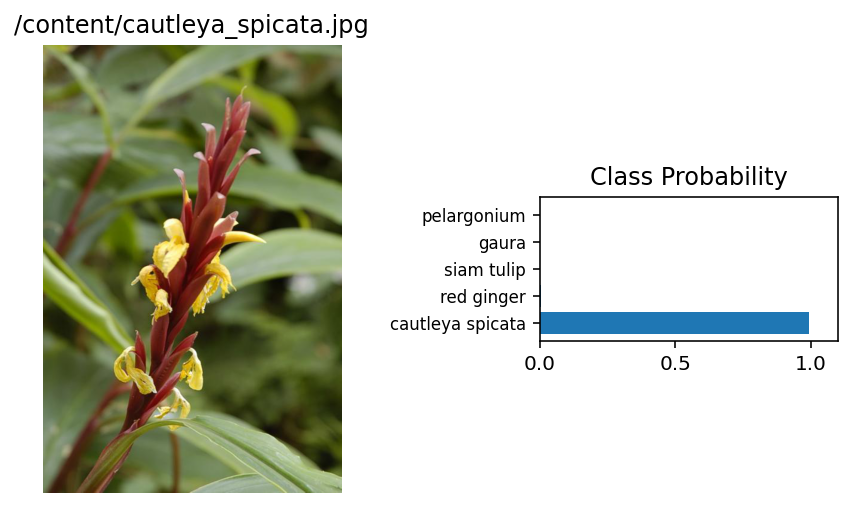

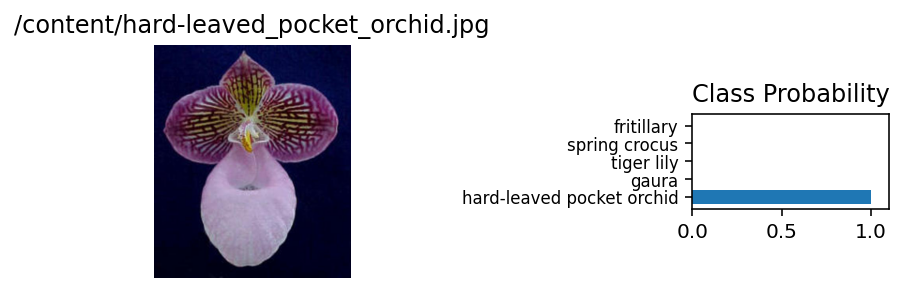

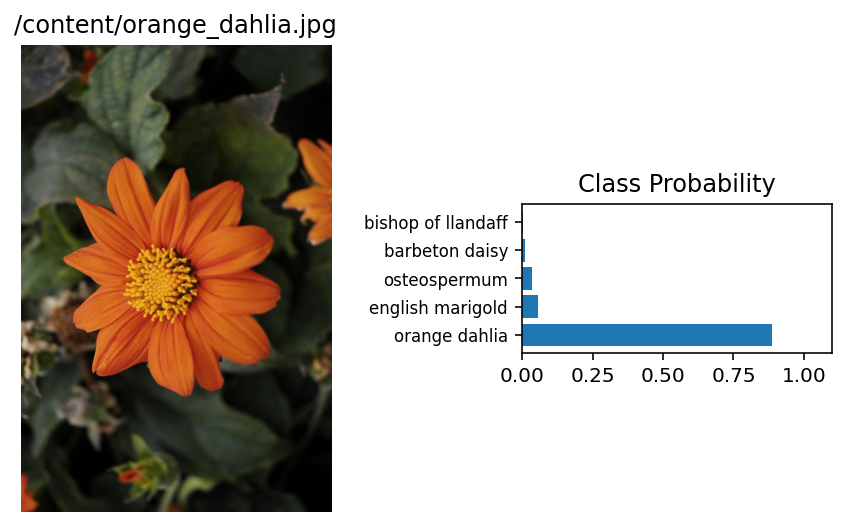

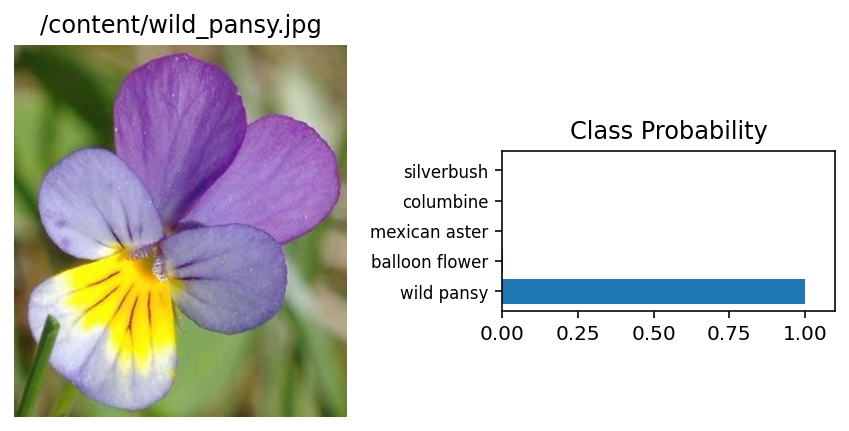

In [64]:
for image in images:
  plot_image(image, reloaded_keras_model, 5)

### Resources

1.Opening Image function (https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open)

2.Solution to h5 keras layer issue when loading h5 model (https://stackoverflow.com/questions/61814614/unknown-layer-keraslayer-when-i-try-to-load-model), (https://knowledge.udacity.com/questions/172354)

3. How to use top_k in Tensorflow (https://www.tensorflow.org/api_docs/python/tf/math/top_k)

4. Expanding dims in order to feed a single image into Tensorflow (https://stackoverflow.com/questions/43017017/keras-model-predict-for-a-single-image)

5. Adding keras layers to a sequential tensorflow object starting with a pre-trained model (https://tensorflow.google.cn/tutorials/images/transfer_learning).

6. Parsing from config line (https://pymotw.com/2/argparse/), (https://docs.python.org/3/library/argparse.html) and (https://pymotw.com/3/argparse/0


7. Issue with json file (https://knowledge.udacity.com/questions/272843)


Re-used udacity code from previous exercises to build loss and accuracy graphs and to save the best_model.h5.
